<div style="text-align:center;">
    <img style="width: 30%;" src="static/imgs/Logo_course.png">
    <p style="margin-top:10px;">paul.andres.munoz@gmail.com<br>paul.munoz@vub.be</p>
</div>

# Unit 2: Download and processing of satellite precipitation data

In this session, we will:

- Access PERSIANN and IMERG data repositories
- Download satellite precipitation images
- Open and georeference satellite precipitation images
- Data manipulation and information generation
- Visualization

# Software for accessing free satellite data repositories

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/FileZilla_download.png"></div>

## Start FileZilla

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/FileZilla.png"></div>

# PERSIANN Data Source

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/PERSIANN_head.png"></div>

Website: http://chrs.web.uci.edu

Available Subproducts:
- PERSIANN
- PERSIANN-CCS
- PERSIANN-CDR
- PERSIANN-IDR

We will focus on the subproduct with the finest spatial/temporal resolution, **PERSIANN-CCS**.

**PERSIANN-CCS** uses satellite images to analyze clouds and predict precipitation worldwide. It was developed at the University of California, Irvine.

The precipitation estimation principle is highly detailed, analyzing the height of clouds and their coverage area. Unlike other methods, PERSIANN-CCS can identify individual clouds and provide specific information about them. This helps determine how much precipitation is falling in different regions. All this information is available in real time and can be easily downloaded.

In summary:

- **Data Period**: 2003 - present.
- **Coverage**: From 60°S to 60°N.
- **Resolution**: 0.04° x 0.04°, approximately 4.4 x 4.4 km per pixel.
- **Available Data**: Every 1 hour, 3 hours, 6 hours, daily, monthly, annually.
- **Latency**: Almost real-time (~2 hours).

## Connect to the PERSIANN Data Repository

Enter the following information:

- **Protocol**: FTP - File Transfer Protocol  
- **Host**: persiann.eng.uci.edu  
- **Logon Type**: Anonymous  

<div style="text-align:center;"><img style="width: 60%;" src="static/imgs/FTP_PERSIANN.png"></div>

Upon connecting, you will have remote access to the PERSIANN data folder.

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/Filezilla_PERSIANN_CCS.png"></div>

## Download Data from the PERSIANN-CCS Repository

Click derecho en la carpeta/archivo que queremos descargar en la carpeta local

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/Filezilla_local.png"></div>

We now have PERSIANN-CCS precipitation files.

## Visualize Data on the Platform

Access the data visualization platform using the following link:

[https://chrsdata.eng.uci.edu](https://chrsdata.eng.uci.edu)

## Open a Precipitation File

Import the necessary libraries:

Ahora cargamos todas las librerías necesarias y ejecutamos una función que luego servirá para definir las fechas:

In [12]:

import gzip
import descartes
import pickle
import numpy as np
from shapely.geometry import mapping
import geopandas as gpd
import os
import glob
import rasterio
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime
import calendar
#import cartopy.crs as ccrs
import pandas as pd
from scipy import signal
import pickle
import h5py
#globe_proj = ccrs.PlateCarree()
def JulianDate_to_MMDDYYY(y,jd):
    month = 1
    day = 0
    while jd - calendar.monthrange(y,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(y,month)[1]
        month = month + 1
    return jd, month

def getLine(data, line_no):
    n = 0
    lastPos = -1
    for i in range(0, len(data) - 1):
        if data[i] == "\n":
            n = n + 1
            if n == line_no:
                return data[lastPos + 1:i]
            else:
                lastPos = i;

    if(n == line_no - 1):
        return data[lastPos + 1:]
    return ""

Define project folder

In [13]:
folder = os.getcwd()
folder

'/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks'

In [14]:
folder_files= folder+'/data/PERSIANN-CCS/Hourly/Global/2023/'
folder_files

'/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/'

Define the name of a file for reading

In [40]:
item=folder_files+'rgccs1h2301500.bin.gz'
item

'/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2301500.bin.gz'

Reading the file

In [41]:
f = gzip.GzipFile(item)
file_content = f.read()
data = np.frombuffer(file_content, dtype=np.dtype('>h')).astype(float) 
data = data.reshape((3000,9000))
data_1 = data[:,4500:]
data_2 = data[:,:4500]
data = np.hstack((data_1,data_2))
data= data/100
data[data < 0] = np.nan
data = np.flipud(data)

In [42]:
data

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Georeferencing the data matrix

In [43]:
lon=np.arange(-180,180,0.04)
lat=np.arange(60,-60,-0.04)
data = xr.DataArray(data=data, dims=["lat", "lon"], coords=[lat,lon])
data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data

<xarray.DataArray (lat: 3000, lon: 9000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 60.0 59.96 59.92 59.88 ... -59.88 -59.92 -59.96
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

Plot the georeferenced global precipitation file

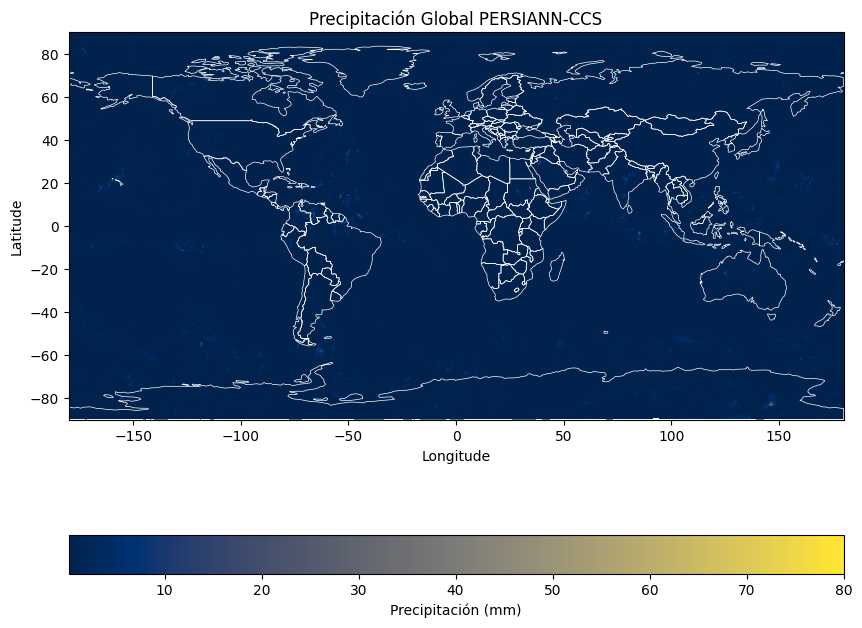

In [50]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(figsize=(10, 10), color='white', linewidth=0.5)
plt.imshow(data, cmap='cividis', vmin=0.1, vmax=80, extent=[-180, 180, -90, 90])
ax.set_aspect('equal')
plt.title("Precipitación Global PERSIANN-CCS")
plt.colorbar(label='Precipitación (mm)', orientation='horizontal')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Extract basic statistics from the data:

In [53]:
print('Maximum precipitation = ',data.max().values,'mm')
print('Average precipitation = ',data.mean().values,'mm')
print('Minimum precipitation = ',data.min().values,'mm')

Maximum precipitation =  78.73 mm
Average precipitation =  0.11433396293872454 mm
Minimum precipitation =  0.0 mm


Load the shapefile of a hydrological system:
- For example, a mountain catchment in Ecuador, South America

In [63]:
data.rio.write_crs("epsg:4326", inplace=True)     
catchment_shp_1 = gpd.read_file(folder+'/Shapefiles/Catchment_SA.shp')

Display the catchment

<AxesSubplot:>

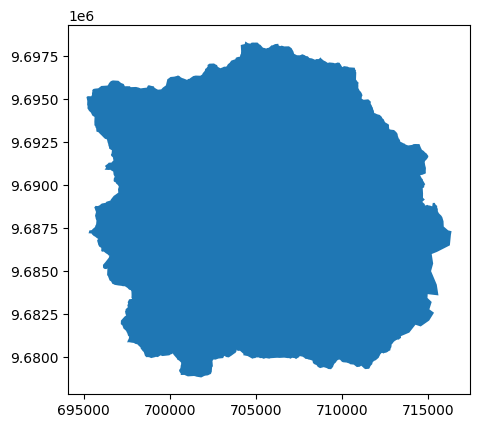

In [64]:
catchment_shp_1.plot()

Clip the global precipitation data to the catchment

In [65]:
data_catchment_1 = data.rio.clip(catchment_shp_1.geometry.apply(mapping),catchment_shp_1.crs,all_touched=True)

Mostrar la precipitación de la cuenca del río Tomebamba

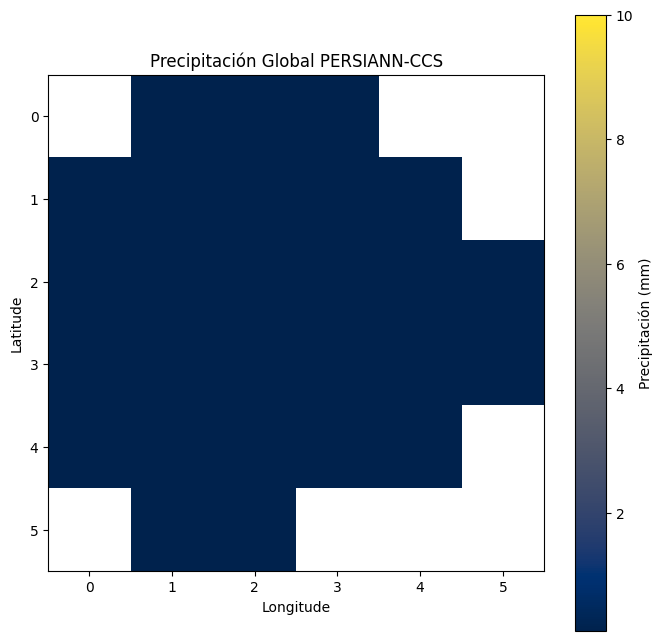

In [66]:
fig = plt.subplots(figsize=(8,8))
plt.imshow(data_catchment_1,cmap='cividis',vmin=0.1,vmax=10)
plt.title("PERSIANN-CCS precipitation")
plt.colorbar(label='Precipitation (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Basic precipitation statistics for the catchment

In [67]:
print('Maximum precipitation = ',data_catchment_1.max().values,'mm')
print('Average precipitation= ',data_catchment_1.mean().values,'mm')
print('Minimum precipitation = ',data_catchment_1.min().values,'mm')

Maximum precipitation =  0.0 mm
Average precipitation=  0.0 mm
Minimum precipitation =  0.0 mm


Now, for another catchment
- Coastal catchment in Ecuador

<AxesSubplot:>

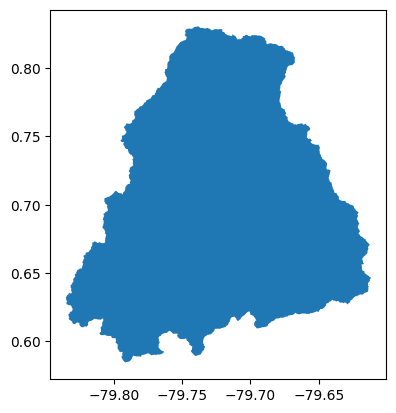

In [69]:
catchment_shp_2 = gpd.read_file(folder+'/Shapefiles/Coastal_catchment.geojson')
catchment_shp_2.plot()

Clip the global precipitation data to the coastal catchment

In [71]:
data_catchment_2 = data.rio.clip(catchment_shp_2.geometry.apply(mapping),catchment_shp_2.crs,all_touched=True)

Mostrar la precipitación en la cuenca

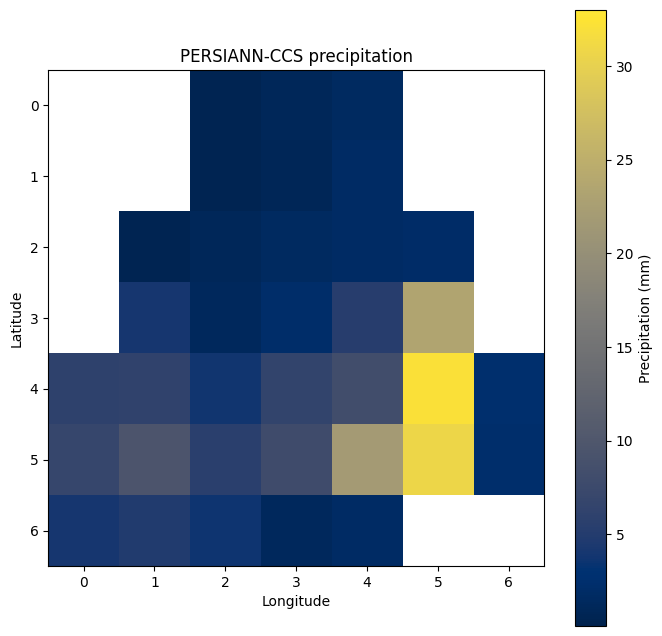

In [74]:
fig = plt.subplots(figsize=(8,8))
plt.imshow(data_catchment_2,cmap='cividis',vmin=0.1,vmax=33)
plt.title("PERSIANN-CCS precipitation")
plt.colorbar(label='Precipitation (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Basic precipitation statistics for the coastal catchment

In [75]:
print('Maximum precipitation = ',data_catchment_2.max().values,'mm')
print('Average precipitation= ',data_catchment_2.mean().values,'mm')
print('Minimum precipitation = ',data_catchment_2.min().values,'mm')

Maximum precipitation =  32.19 mm
Average precipitation=  6.167428571428572 mm
Minimum precipitation =  0.53 mm


**Now read all the downloaded precipitation files**

Create a list for the downloaded files

In [76]:
folder_files
file_extension = "*.bin.gz"  
list_of_Files = glob.glob(os.path.join(folder_files, file_extension))
list_of_Files = [file_name for file_name in list_of_Files if not file_name.startswith('.DS_Store')]
list_of_Files.sort()

Display the list

In [77]:
list_of_Files[:10]

['/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2300100.bin.gz',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2300101.bin.gz',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2300102.bin.gz',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2300103.bin.gz',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2300104.bin.gz',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2300105.bin.gz',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hourly/Global/2023/rgccs1h2300106.bin.gz',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/PERSIANN-CCS/Hou

Read the files, one by one, and calculate the accumulated precipitation for the first 15 days of January 2023

In [78]:
data_sum = xr.DataArray(data=np.empty((3000, 9000)), dims=["lat", "lon"])
for index, item in enumerate(list_of_Files):
    print(index+1, 'out of', len(list_of_Files))
    f=gzip.GzipFile(item)
    try:
        file_content = f.read()
    except (IOError, EOFError) as e:
        continue
    data = np.frombuffer(file_content, dtype=np.dtype('>h')).astype(float)
    data = data.reshape((3000,9000))
    data_1 = data[:,4500:]
    data_2 = data[:,:4500]
    data = np.hstack((data_1,data_2))
    data= data/100
    data[data < 0] = np.nan 
    data = np.flipud(data)
    data = xr.DataArray(data=data, dims=["lat", "lon"], coords=[lat,lon])
    data_sum+=data

1 out of 337
2 out of 337
3 out of 337
4 out of 337
5 out of 337
6 out of 337
7 out of 337
8 out of 337
9 out of 337
10 out of 337
11 out of 337
12 out of 337
13 out of 337
14 out of 337
15 out of 337
16 out of 337
17 out of 337
18 out of 337
19 out of 337
20 out of 337
21 out of 337
22 out of 337
23 out of 337
24 out of 337
25 out of 337
26 out of 337
27 out of 337
28 out of 337
29 out of 337
30 out of 337
31 out of 337
32 out of 337
33 out of 337
34 out of 337
35 out of 337
36 out of 337
37 out of 337
38 out of 337
39 out of 337
40 out of 337
41 out of 337
42 out of 337
43 out of 337
44 out of 337
45 out of 337
46 out of 337
47 out of 337
48 out of 337
49 out of 337
50 out of 337
51 out of 337
52 out of 337
53 out of 337
54 out of 337
55 out of 337
56 out of 337
57 out of 337
58 out of 337
59 out of 337
60 out of 337
61 out of 337
62 out of 337
63 out of 337
64 out of 337
65 out of 337
66 out of 337
67 out of 337
68 out of 337
69 out of 337
70 out of 337
71 out of 337
72 out of 337
7

In [79]:
data_sum

<xarray.DataArray (lat: 3000, lon: 9000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 60.0 59.96 59.92 59.88 ... -59.88 -59.92 -59.96
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

Recortar la precipitación satelital acumulada a la cuenca del Tomebamba y georeferenciar

In [82]:
data_sum.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data_sum.rio.write_crs("epsg:4326", inplace=True)       
data_catchment_1 = data_sum.rio.clip(catchment_shp_1.geometry.apply(mapping),catchment_shp_1.crs,all_touched=True)

Graficar y mostrar estadísticos básicos

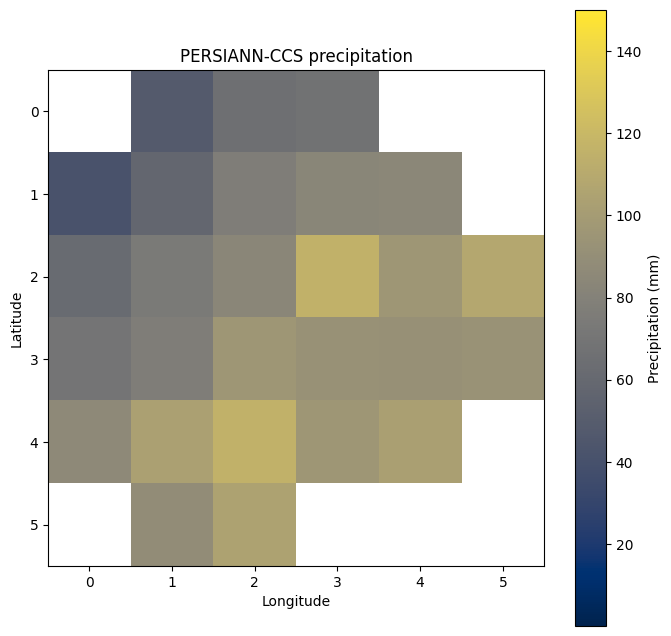

Maximum precipitación =  115.69000000000004 mm
Average precipitación =  84.5777777777778 mm
Minimum precipitación =  41.260000000000005 mm


In [87]:
fig = plt.subplots(figsize=(8,8))
plt.imshow(data_catchment_1,cmap='cividis',vmin=0.1,vmax=150)
plt.title("PERSIANN-CCS precipitation")
plt.colorbar(label='Precipitation (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
print('Maximum precipitación = ',data_catchment_1.max().values,'mm')
print('Average precipitación = ',data_catchment_1.mean().values,'mm')
print('Minimum precipitación = ',data_catchment_1.min().values,'mm')

Now for the coastal catchment

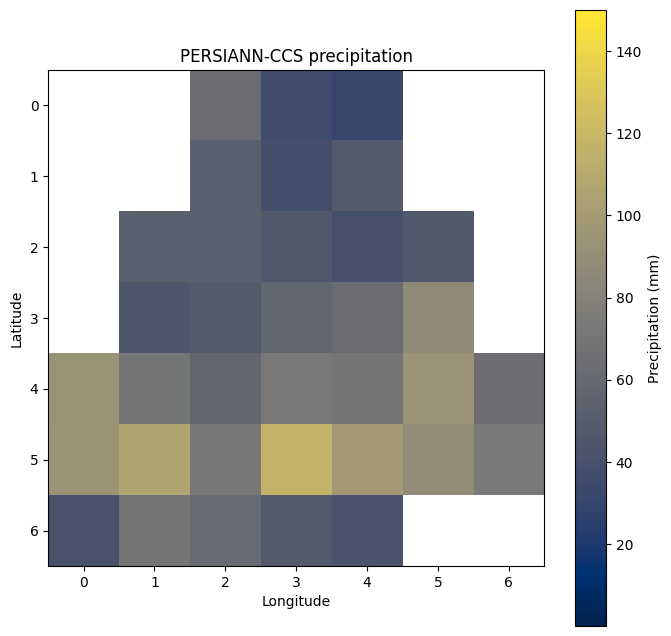

Maximum precipitación =  116.85000000000002 mm
Average precipitación =  64.34514285714286 mm
Minimum precipitación =  30.730000000000004 mm


In [89]:
data_catchment_2 = data_sum.rio.clip(catchment_shp_2.geometry.apply(mapping),catchment_shp_2.crs,all_touched=True)
fig = plt.subplots(figsize=(8,8))
plt.imshow(data_catchment_2,cmap='cividis',vmin=0.1,vmax=150)
plt.title("PERSIANN-CCS precipitation")
plt.colorbar(label='Precipitation (mm)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
print('Maximum precipitación = ',data_catchment_2.max().values,'mm')
print('Average precipitación = ',data_catchment_2.mean().values,'mm')
print('Minimum precipitación = ',data_catchment_2.min().values,'mm')

Generate a dataFrame with precipitation time series (for each pixel):

- Example: In the mountain catchment, time series for January 1, 2023.

In [103]:
for index, item in enumerate(list_of_Files[:24]):
    print(index+1, 'out of', len(list_of_Files[:24]))
    f=gzip.GzipFile(item)
    try:
        file_content = f.read()
    except (IOError, EOFError) as e:
        continue
    data = np.frombuffer(file_content, dtype=np.dtype('>h')).astype(float)  # Convert to float
    data = data.reshape((3000,9000))
    data_1 = data[:,4500:]
    data_2 = data[:,:4500]
    data = np.hstack((data_1,data_2))
    data= data/100
    data[data < 0] = np.nan  
    data = np.flipud(data)
    data = xr.DataArray(data=data, dims=["lat", "lon"], coords=[lat,lon])
    data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    data.rio.write_crs("epsg:4326", inplace=True)       
    data = data.rio.clip(catchment_shp_1.geometry.apply(mapping),catchment_shp_1.crs,all_touched=True)
    data = data.values.flatten()
    date_att = str(item)
    year = int('20'+str(date_att[-14:-12]))
    julian_day = int(str(date_att[-12:-9]))
    day, month = JulianDate_to_MMDDYYY(year,julian_day)
    hour = int(str(date_att[-9:-7]))
    date = datetime.datetime(int(year), int(month), day, hour, 0, 0)
    data = pd.DataFrame(data)
    data = data.dropna() 
    data = data.T
    data = data.set_index(pd.DatetimeIndex([date]))
    if index==0:
        dataset=data.copy()
    else:       
        dataset = dataset.append(data)

1 out of 24
2 out of 24
3 out of 24
4 out of 24
5 out of 24
6 out of 24
7 out of 24
8 out of 24
9 out of 24
10 out of 24
11 out of 24
12 out of 24
13 out of 24
14 out of 24
15 out of 24
16 out of 24
17 out of 24
18 out of 24
19 out of 24
20 out of 24
21 out of 24
22 out of 24
23 out of 24
24 out of 24


Preprocesar la información y remover datos duplicados

In [104]:
dataset.shape

(24, 27)

In [105]:
dataset = dataset.sort_index()
dataset = dataset[~dataset.index.duplicated(keep='first')]
dataset

,1,2,3,6,7,8,9,10,12,13,...,21,22,23,24,25,26,27,28,31,32
2023-01-01 00:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 01:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 02:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 03:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 04:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 05:00:00,0.0,0.0,0.26,0.0,0.0,0.0,2.57,0.0,0.0,0.0,...,0.09,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 06:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 07:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 08:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 09:00:00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Exportar esta información en formato **csv**

In [106]:
dataset.to_csv(folder_files+"PERSIANN-CCS_UTC_Catchment_1.csv", index=True)

Graficar la precipitación satelital extraída 

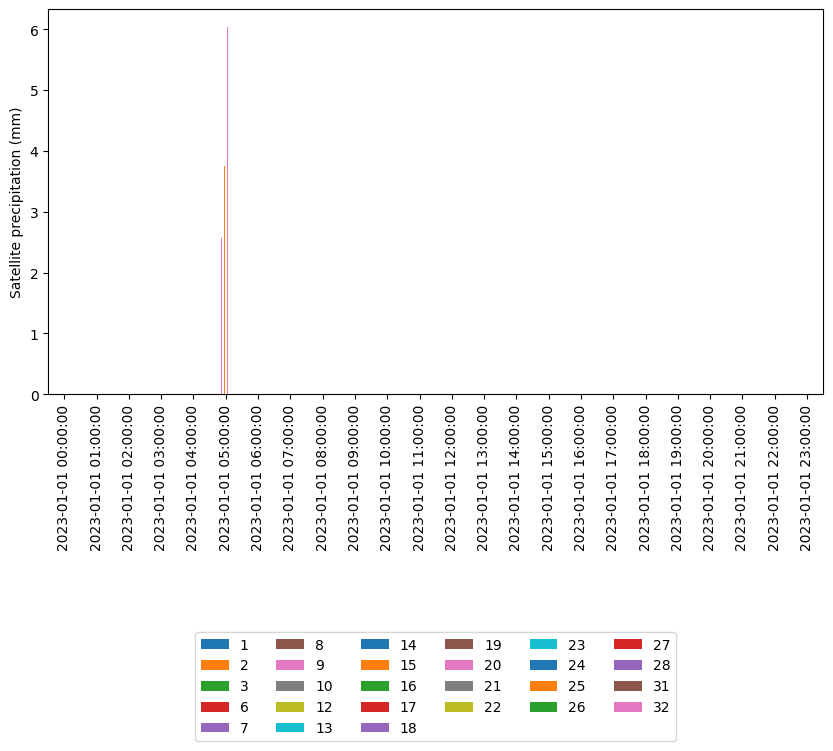

In [107]:
fig, ax = plt.subplots(figsize=(10,5))
dataset.plot(kind='bar', ax=ax)
ax.legend(title='Legend Title')
plt.ylabel('Satellite precipitation (mm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=6)
plt.show()

Calcular y graficar la precipitación acumulada

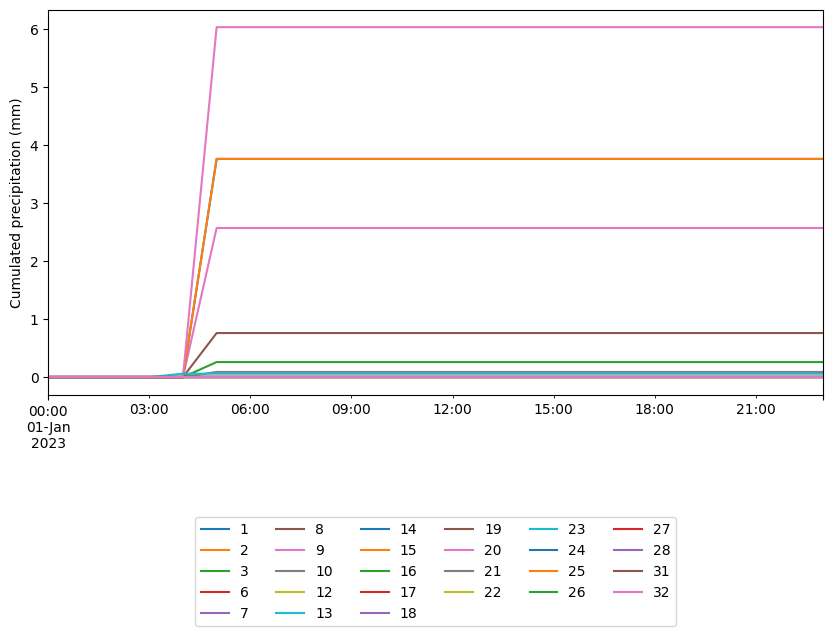

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
dataset.cumsum().plot(ax=ax)
ax.legend(title='Legend Title')
plt.ylabel('Cumulated precipitation (mm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=6)
plt.show()

# Fuentes de datos IMERG

Página web: https://gpm.nasa.gov/data/imerg

Subproductos disponibles:
- Early Run
- Late Run
- Final Run

Vamos a centrarnos en el subproducto con la resolución espacial/temporal más fina, IMERG-Early Run.


## Registro previo para descargar datos IMERG

Registrarse en el siguiente link:

https://registration.pps.eosdis.nasa.gov/registration/newContact.html

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/IMERG_registration.png"></div>


Una vez registrados, confirmamos desde el correo electrónico.

## Conectarse al repositorio de datos IMERG

Ingresamos la siguiente información:

- **Protocol:** FTP - File Transfer Protocol

- **Host:** jsimpsonftps.pps.eosdis.nasa.gov

- **Logon type:** Normal, ingresar usuario y contraseña

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/IMERG_FTP.png"></div>

Al conectarse, tenemos acceso remoto a la carpeta de datos de IMERG

<div style="text-align:center;"><img style="width: 100%;" src="static/imgs/IMERG_server.png"></div>

## Descargar información del repositorio de IMERG-Early Run

Click derecho en la carpeta/archivo que queremos descargar en la carpeta local.

## Abrir un archivo de precipitación de IMERG

Definr carpeta de datos IMERG-ER

In [110]:
folder = os.getcwd()
folder_files= folder+'/data/IMERG-ER/Hourly/Global/202301/'
folder_files

'/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/'

Crear una lista con archivos de precipitación del 31 de enero de 2023

In [111]:
list_of_Files = glob.glob(folder_files + '/*H5')
list_of_Files.sort()

Mostrar la lista 

In [112]:
list_of_Files

['/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S000000-E002959.0000.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S003000-E005959.0030.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S010000-E012959.0060.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S013000-E015959.0090.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S020000-E022959.0120.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S023000-E02595

Definir la ruta de un archivo para su lectura

In [113]:
item=folder_files+'3B-HHR-E.MS.MRG.3IMERG.20230131-S000000-E002959.0000.V06C.RT-H5'
item

'/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S000000-E002959.0000.V06C.RT-H5'

Abrir archivo de precipitación

In [114]:
data = h5py.File( item, 'r' )
precip = data['/Grid/precipitationCal'][:]
precip = np.flip( precip[0,:,:].transpose(), axis=0 )

Mostrar matriz de datos leída

In [115]:
precip

array([[    0. ,     0. ,     0. , ...,     0. ,     0. ,     0. ],
       [    0. ,     0. ,     0. , ...,     0. ,     0. ,     0. ],
       [    0. , -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       ...,
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9]],
      dtype=float32)

Estadísticos básicos

In [116]:
print('Precipitación máxima = ',precip.max(),'mm')
print('Precipitación promedio = ',precip.mean(),'mm')
print('Precipitación mínima = ',precip.min(),'mm')

Precipitación máxima =  77.89 mm
Precipitación promedio =  -2579.9229 mm
Precipitación mínima =  -9999.9 mm


Mostrar la información de precipitación global

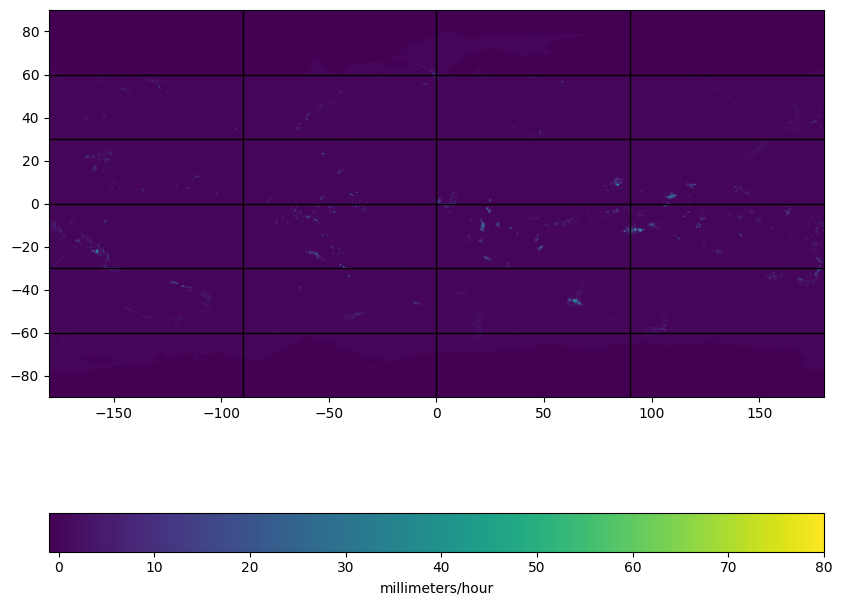

In [117]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(precip, vmin=-1, vmax=80, extent=[-180, 180, -90, 90])
cbar = plt.colorbar(im, orientation='horizontal')
cbar.set_label('millimeters/hour')
for lon in np.arange(-90, 90+1, 90):
    plt.plot((lon, lon), (-90, +90), color="black", linewidth=1)
for lat in np.arange(-60, 60+1, 30):
    plt.plot((-180, +180), (lat, lat), color="black", linewidth=1)
plt.show()

Georeferenciar y recortar la precipitación global para la cuenca del río Tomebamba

In [120]:
precip

array([[    0. ,     0. ,     0. , ...,     0. ,     0. ,     0. ],
       [    0. ,     0. ,     0. , ...,     0. ,     0. ,     0. ],
       [    0. , -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       ...,
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9],
       [-9999.9, -9999.9, -9999.9, ..., -9999.9, -9999.9, -9999.9]],
      dtype=float32)

In [122]:
lat = data['/Grid/lat'][:]
lon = data['/Grid/lon'][:]
catchment_shp_1 = gpd.read_file(folder+'/Shapefiles/Catchment_SA.shp')
data = xr.DataArray(data=precip, dims=["lat", "lon"], coords=[lat,lon])
data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data.rio.write_crs("epsg:4326", inplace=True)       
data_catchment_1= data.rio.clip(catchment_shp_1.geometry.apply(mapping),catchment_shp_1.crs,all_touched=True)

Graficar la precipitación para la cuenca del Tomebamba

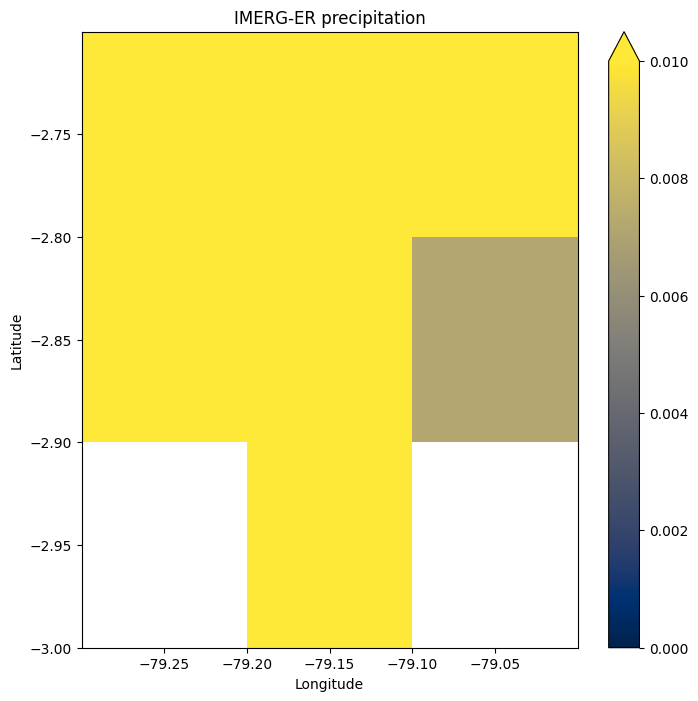

In [123]:
fig = plt.subplots(figsize=(8,8))
data_catchment_1.plot(cmap='cividis',vmin=0,vmax=0.01)
plt.title("IMERG-ER precipitation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Estadísticos básicos

In [127]:
print('Precipitación máxima = ',data_catchment_1.max().values,'mm')
print('Precipitación promedio = ',data_catchment_1.mean().values,'mm')
print('Precipitación mínima = ',data_catchment_1.min().values,'mm')

Precipitación máxima =  0.09930742 mm
Precipitación promedio =  0.050089043 mm
Precipitación mínima =  0.00717021 mm


Ahora para la cuenca en Esmeraldas

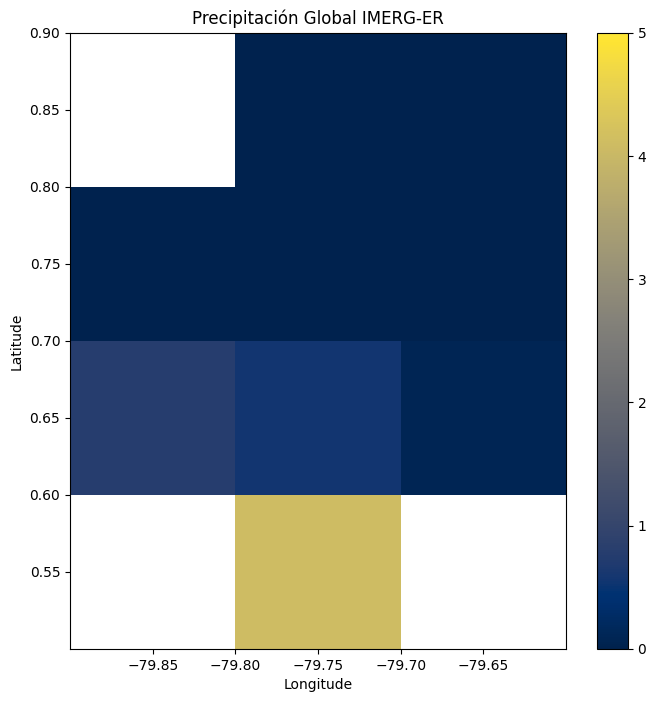

Precipitación máxima =  4.086399 mm
Precipitación promedio =  0.6110221 mm
Precipitación mínima =  0.0 mm


In [128]:
catchment_shp_2 = gpd.read_file(folder+'/Shapefiles/Coastal_catchment.geojson')
data_catchment_2 = data.rio.clip(catchment_shp_2.geometry.apply(mapping),catchment_shp_2.crs,all_touched=True)
fig = plt.subplots(figsize=(8,8))
data_catchment_2.plot(cmap='cividis',vmin=0,vmax=5)
plt.title("Precipitación Global IMERG-ER")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
print('Precipitación máxima = ',data_catchment_2.max().values,'mm')
print('Precipitación promedio = ',data_catchment_2.mean().values,'mm')
print('Precipitación mínima = ',data_catchment_2.min().values,'mm')

Leer y procesar todos los archivos IMERG-ER

Mostrar la lista

In [129]:
list_of_Files

['/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S000000-E002959.0000.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S003000-E005959.0030.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S010000-E012959.0060.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S013000-E015959.0090.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S020000-E022959.0120.V06C.RT-H5',
 '/Users/paul/Documents/GitHub/ML_hydrological_forecasting/notebooks/data/IMERG-ER/Hourly/Global/202301/3B-HHR-E.MS.MRG.3IMERG.20230131-S023000-E02595

Acumular la precipitación

In [130]:
data_sum = xr.DataArray(data=np.empty((1800, 3600)), dims=["lat", "lon"])
for index, item in enumerate(list_of_Files):
    print(index+1, 'out of', len(list_of_Files))
    try:
        data = h5py.File(item, 'r')        
        precip = data['/Grid/precipitationCal'][:]
        precip[precip < 0] = np.nan 
        precip = np.flip(precip[0,:,:].transpose(), axis=0) 
        theLats = data['Grid/lat'][:]
        theLons = data['Grid/lon'][:]
        x, y = np.meshgrid(theLons, theLats)
        
        precip = xr.DataArray(precip, dims=('lat', 'lon'), coords={'lat' : theLats, 'lon' : theLons})
        
        data_sum += precip
        
        data.close()
        
    except (IOError, EOFError) as e:
        continue

1 out of 48
2 out of 48
3 out of 48
4 out of 48
5 out of 48
6 out of 48
7 out of 48
8 out of 48
9 out of 48
10 out of 48
11 out of 48
12 out of 48
13 out of 48
14 out of 48
15 out of 48
16 out of 48
17 out of 48
18 out of 48
19 out of 48
20 out of 48
21 out of 48
22 out of 48
23 out of 48
24 out of 48
25 out of 48
26 out of 48
27 out of 48
28 out of 48
29 out of 48
30 out of 48
31 out of 48
32 out of 48
33 out of 48
34 out of 48
35 out of 48
36 out of 48
37 out of 48
38 out of 48
39 out of 48
40 out of 48
41 out of 48
42 out of 48
43 out of 48
44 out of 48
45 out of 48
46 out of 48
47 out of 48
48 out of 48


Graficar la información de precipitación acumulada del 31 de enero de 2023

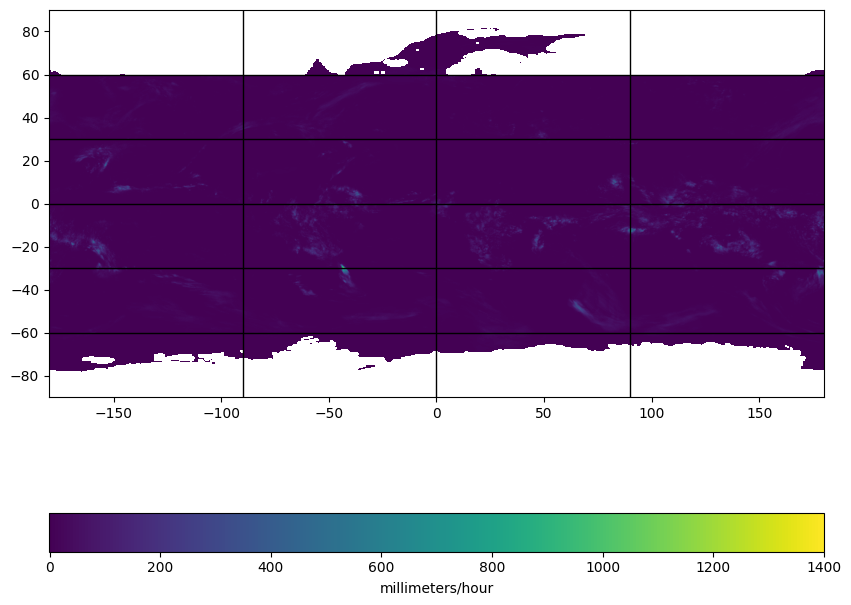

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(data_sum, vmin=-1, vmax=1400, extent=[-180, 180, -90, 90])
cbar = plt.colorbar(im, orientation='horizontal')
cbar.set_label('millimeters/hour')

for lon in np.arange(-90, 90+1, 90):
    plt.plot((lon, lon), (-90, +90), color="black", linewidth=1)
for lat in np.arange(-60, 60+1, 30):
    plt.plot((-180, +180), (lat, lat), color="black", linewidth=1)

plt.show()

Recortar esa información para la cuenca del Tomebamba

In [135]:
data_sum.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data_sum.rio.write_crs("epsg:4326", inplace=True)   
data_sum_catchment_1= data_sum.rio.clip(catchment_shp_1.geometry.apply(mapping),catchment_shp_1.crs,all_touched=True)
data_sum_catchment_1

<xarray.DataArray (lat: 3, lon: 3)>
array([[        nan, 15.43885659,         nan],
       [ 8.32326977,  9.09369504,  8.29173989],
       [ 5.1493402 ,  6.15480427,  4.62113877]])
Coordinates:
  * lat          (lat) float64 -2.95 -2.85 -2.75
  * lon          (lon) float64 -79.25 -79.15 -79.05
    spatial_ref  int64 0

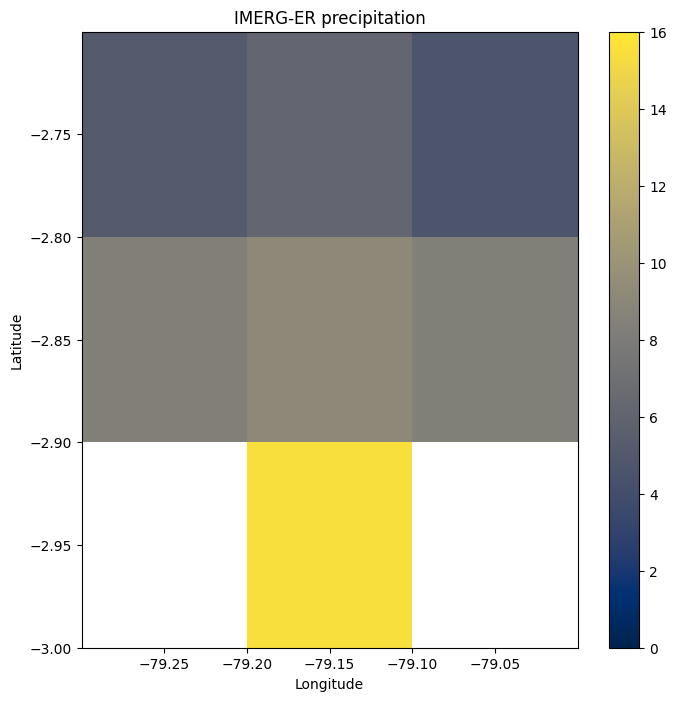

Precipitación máxima =  15.438856594264507 mm
Precipitación promedio =  8.153263505681284 mm
Precipitación mínima =  4.621138773858547 mm


In [137]:
fig = plt.subplots(figsize=(8,8))
data_sum_catchment_1.plot(cmap='cividis',vmin=0,vmax=16)
plt.title("IMERG-ER precipitation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
print('Precipitación máxima = ',data_sum_catchment_1.max().values,'mm')
print('Precipitación promedio = ',data_sum_catchment_1.mean().values,'mm')
print('Precipitación mínima = ',data_sum_catchment_1.min().values,'mm')

Ahora para la cuenca en Esmeraldas

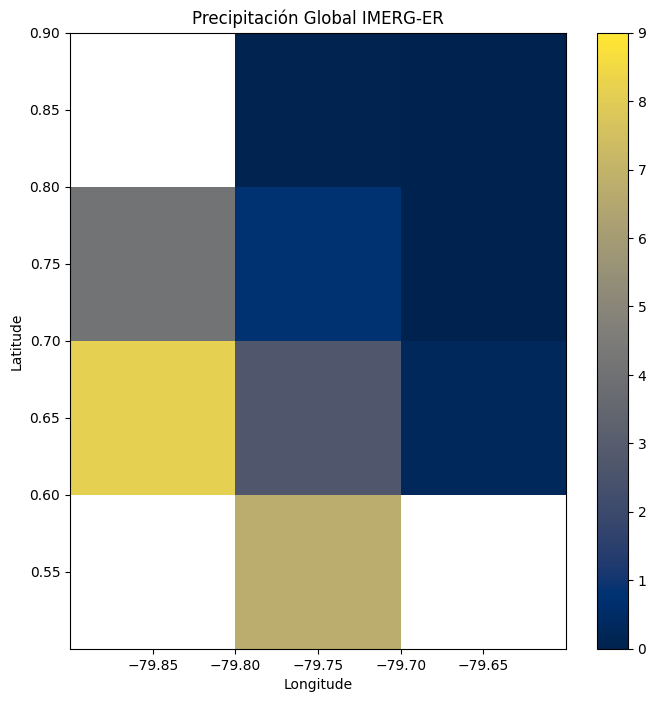

Precipitación máxima =  8.14799827337265 mm
Precipitación promedio =  2.533955109616121 mm
Precipitación mínima =  0.0 mm


In [138]:
data_sum = xr.DataArray(data_sum, dims=('lat', 'lon'), coords={'lat' : theLats, 'lon' : theLons})
data_sum.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
data_sum.rio.write_crs("epsg:4326", inplace=True)   
data_sum_catchment_2= data_sum.rio.clip(catchment_shp_2.geometry.apply(mapping),catchment_shp_2.crs,all_touched=True)
fig = plt.subplots(figsize=(8,8))
data_sum_catchment_2.plot(cmap='cividis',vmin=0,vmax=9)
plt.title("Precipitación Global IMERG-ER")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
print('Precipitación máxima = ',data_sum_catchment_2.max().values,'mm')
print('Precipitación promedio = ',data_sum_catchment_2.mean().values,'mm')
print('Precipitación mínima = ',data_sum_catchment_2.min().values,'mm')

Generación de base de datos con las series temporales (pixeles) de precipitación en la cuenca del Tomebamba

In [139]:
for index, item in enumerate(list_of_Files):
    print(index+1, 'out of',len(list_of_Files))
    try:
        data = h5py.File(item, 'r')
    except (IOError, EOFError) as e:    
        continue
    precip = data['/Grid/precipitationCal'][:]
    precip[precip < 0] = np.nan 
    precip = np.flip( precip[0,:,:].transpose(), axis=0)
    precip = xr.DataArray(precip, dims=('lat', 'lon'), coords={'lat' : theLats, 'lon' : theLons})
    precip.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    precip.rio.write_crs("epsg:4326", inplace=True)   
    precip= precip.rio.clip(catchment_shp_1.geometry.apply(mapping),catchment_shp_1.crs,all_touched=True)  
    precip = precip.values.flatten()
    year = int(item[-40:-36])
    month = int(item[-36:-34])
    day = int(item[-34:-32])
    hour = int(item[-22:-20])
    minute = int(item[-20:-18])
    date = datetime.datetime(year, month, day, hour, minute, 0)
    data = pd.DataFrame(precip)
    data = data.dropna()
    data = data.T
    data.set_index(pd.DatetimeIndex([date]),inplace=True)
    if index==0:
        dataset=data.copy()
    else:       
        dataset = dataset.append(data)

dataset = dataset.resample('H',label='right',closed='right').sum() #nan = 0


1 out of 48
2 out of 48
3 out of 48
4 out of 48
5 out of 48
6 out of 48
7 out of 48
8 out of 48
9 out of 48
10 out of 48
11 out of 48
12 out of 48
13 out of 48
14 out of 48
15 out of 48
16 out of 48
17 out of 48
18 out of 48
19 out of 48
20 out of 48
21 out of 48
22 out of 48
23 out of 48
24 out of 48
25 out of 48
26 out of 48
27 out of 48
28 out of 48
29 out of 48
30 out of 48
31 out of 48
32 out of 48
33 out of 48
34 out of 48
35 out of 48
36 out of 48
37 out of 48
38 out of 48
39 out of 48
40 out of 48
41 out of 48
42 out of 48
43 out of 48
44 out of 48
45 out of 48
46 out of 48
47 out of 48
48 out of 48


Mostrar el dataframe

In [140]:
dataset

,1,3,4,5,6,7,8
2023-01-31 01:00:00,0.148423,0.198615,0.126196,0.014340,0.096081,0.094647,0.022945
2023-01-31 02:00:00,0.074212,0.099307,0.063098,0.007170,0.048040,0.047323,0.011472
2023-01-31 03:00:00,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000
2023-01-31 04:00:00,0.000000,0.000000,0.000000,0.000000,0.016658,0.016658,0.000000
2023-01-31 05:00:00,0.000000,0.000000,0.000000,0.000000,0.009997,0.009997,0.000000
2023-01-31 06:00:00,0.000000,0.000000,0.000000,0.040000,0.180000,0.020000,0.040000
2023-01-31 07:00:00,0.000000,0.010000,0.000000,0.014525,0.085364,0.007263,0.014525
2023-01-31 08:00:00,0.000000,0.016658,0.000000,0.000000,0.033315,0.000000,0.000000
2023-01-31 09:00:00,0.000000,0.009997,0.000000,0.000000,0.019993,0.000000,0.000000
2023-01-31 10:00:00,0.000000,0.006834,0.000000,0.000000,0.013667,0.000000,0.000000


Exportar el dataframe

In [141]:
dataset.to_csv(folder_files+"IMERG-ER_UTC_Catchment_1.csv", index=True)  

Graficar las series de precipitación

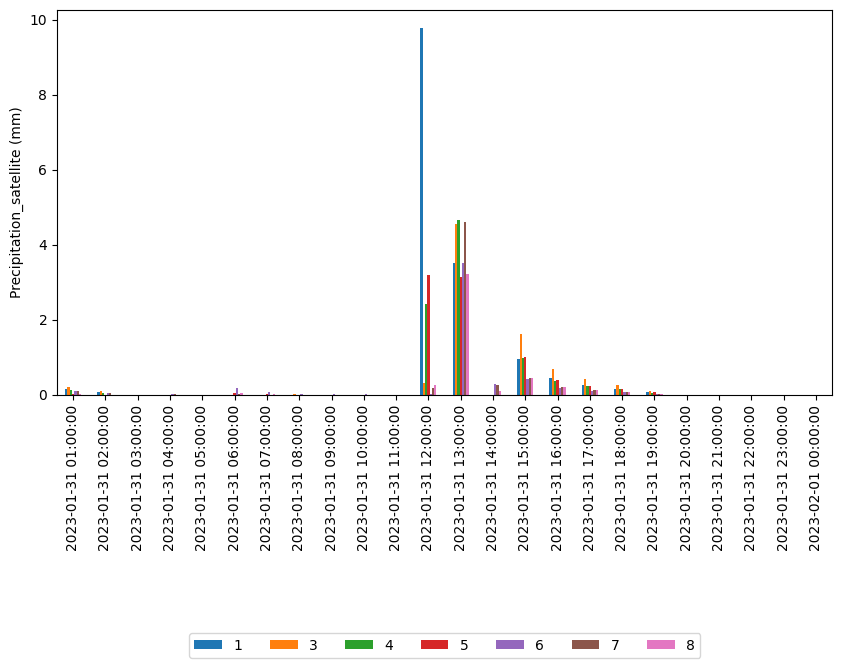

In [143]:
fig, ax = plt.subplots(figsize=(10,5))
dataset.plot(kind='bar', ax=ax)
ax.legend(title='Legend Title')
plt.ylabel('Precipitation_satellite (mm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=7)
plt.show()

Graficar la precipitación acumulada

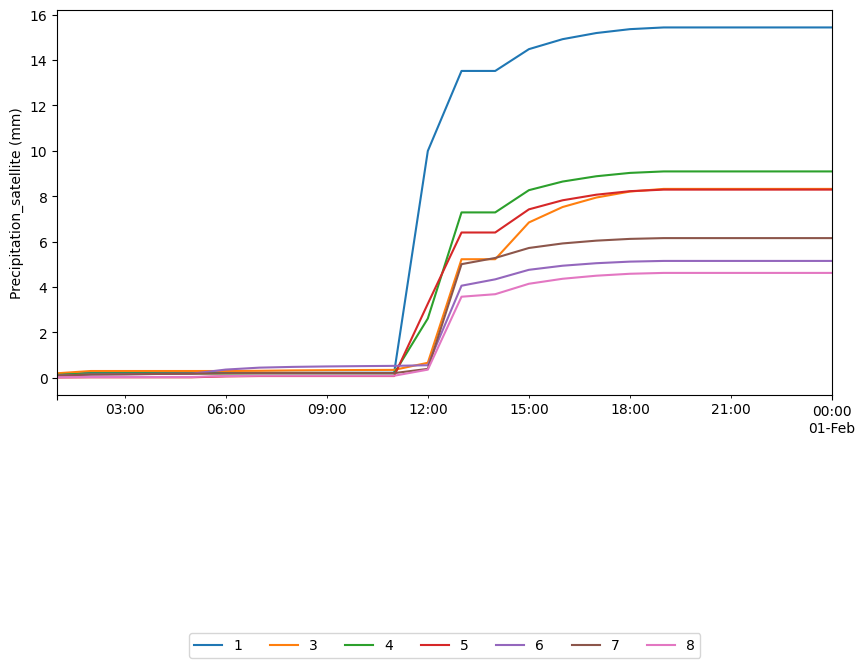

In [145]:
fig, ax = plt.subplots(figsize=(10,5))
dataset.cumsum().plot( ax=ax)
ax.legend(title='Legend Title')
plt.ylabel('Precipitation_satellite (mm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=7)
plt.show()

Lo mismo para la cuenca de Esmeraldas

In [146]:
for index, item in enumerate(list_of_Files):
    print(index+1, 'out of',len(list_of_Files))
    try:
        data = h5py.File(item, 'r')
    except (IOError, EOFError) as e:    
        continue
    precip = data['/Grid/precipitationCal'][:]
    precip[precip < 0] = np.nan 
    precip = np.flip( precip[0,:,:].transpose(), axis=0)
    precip = xr.DataArray(precip, dims=('lat', 'lon'), coords={'lat' : theLats, 'lon' : theLons})
    precip.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    precip.rio.write_crs("epsg:4326", inplace=True)   
    precip= precip.rio.clip(catchment_shp_2.geometry.apply(mapping),catchment_shp_2.crs,all_touched=True)  
    precip = precip.values.flatten()
    year = int(item[-40:-36])
    month = int(item[-36:-34])
    day = int(item[-34:-32])
    hour = int(item[-22:-20])
    minute = int(item[-20:-18])
    date = datetime.datetime(year, month, day, hour, minute, 0)
    data = pd.DataFrame(precip)
    data = data.dropna()
    data = data.T
    data.set_index(pd.DatetimeIndex([date]),inplace=True)
    if index==0:
        dataset=data.copy()
    else:       
        dataset = dataset.append(data)

dataset = dataset.resample('H',label='right',closed='right').sum() 


1 out of 48
2 out of 48
3 out of 48
4 out of 48
5 out of 48
6 out of 48
7 out of 48
8 out of 48
9 out of 48
10 out of 48
11 out of 48
12 out of 48
13 out of 48
14 out of 48
15 out of 48
16 out of 48
17 out of 48
18 out of 48
19 out of 48
20 out of 48
21 out of 48
22 out of 48
23 out of 48
24 out of 48
25 out of 48
26 out of 48
27 out of 48
28 out of 48
29 out of 48
30 out of 48
31 out of 48
32 out of 48
33 out of 48
34 out of 48
35 out of 48
36 out of 48
37 out of 48
38 out of 48
39 out of 48
40 out of 48
41 out of 48
42 out of 48
43 out of 48
44 out of 48
45 out of 48
46 out of 48
47 out of 48
48 out of 48


Mostrar el dataframe

In [147]:
dataset

,1,3,4,5,6,7,8,10,11
2023-01-31 01:00:00,6.686399,5.629199,2.3996,0.2956,0.770000,0.2796,0.0316,0.0000,0.0
2023-01-31 02:00:00,0.038400,2.518800,0.3160,0.0000,3.309999,0.4632,0.0000,0.0672,0.0
2023-01-31 03:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0
2023-01-31 04:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0
2023-01-31 05:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0
2023-01-31 06:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0
2023-01-31 07:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0
2023-01-31 08:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0
2023-01-31 09:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0
2023-01-31 10:00:00,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.0


Exportar el dataframe

In [148]:
dataset.to_csv(folder_files+"IMERG-ER_UTC_Catchment_2.csv", index=True)  

Graficar las series de precipitación

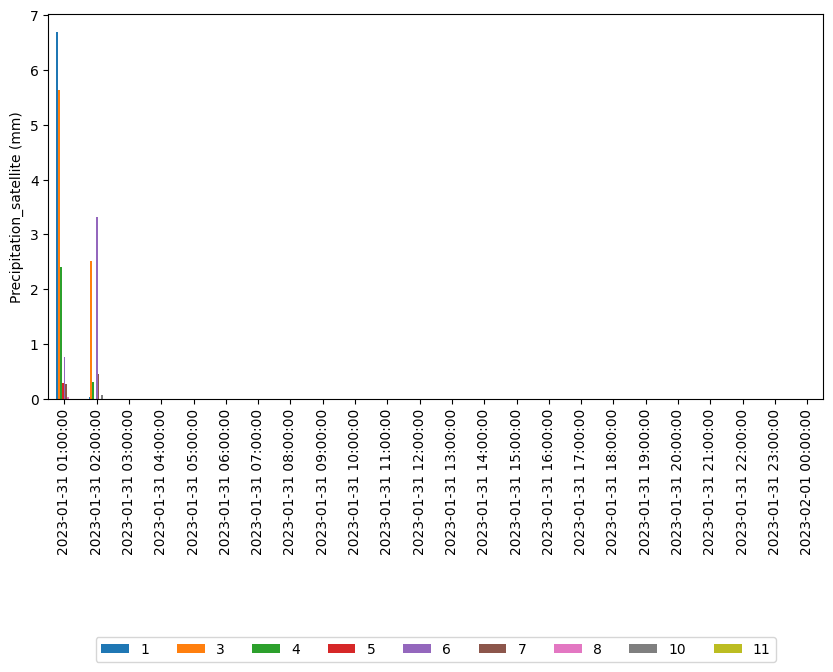

In [149]:
fig, ax = plt.subplots(figsize=(10,5))
dataset.plot(kind='bar', ax=ax)
ax.legend(title='Legend Title')
plt.ylabel('Precipitation_satellite (mm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=9)
plt.show()

Graficar precipitación acumulada

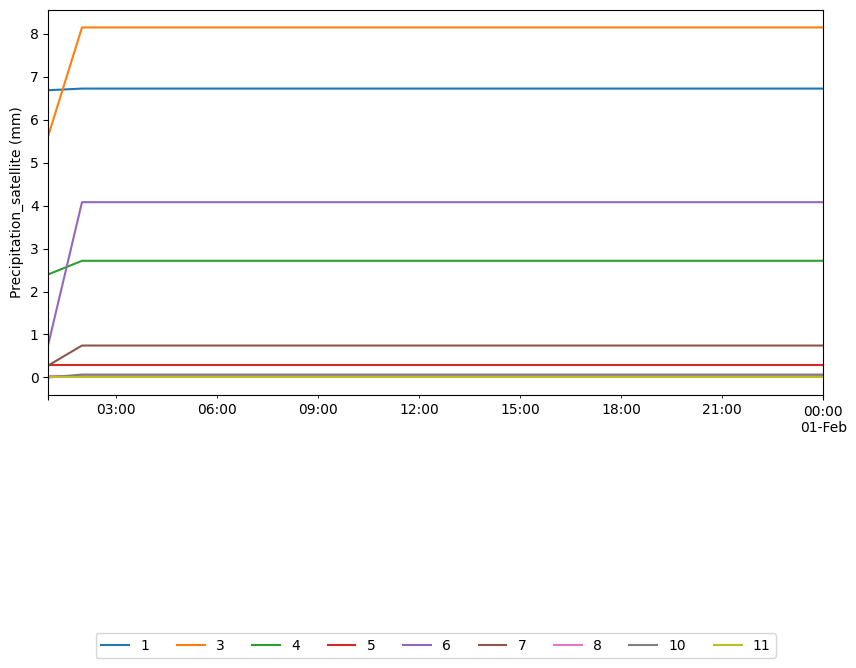

In [151]:
fig, ax = plt.subplots(figsize=(10,5))
dataset.cumsum().plot( ax=ax)
ax.legend(title='Legend Title')
plt.ylabel('Precipitation_satellite (mm)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.6), ncol=9)
plt.show()